In [72]:
from itertools import combinations

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

# RQ 3 + 4

In [70]:
rq34 = pd.read_csv("./data/rq_3_4.csv")
print(len(rq34))

3814162


In [71]:
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
rq34['sentiment_score'] = rq34['text_sentiment'].map(sentiment_mapping)
 
rq34['is_negative'] = rq34['text_sentiment'] == 'negative'
rq34['is_positive'] = rq34['text_sentiment'] == 'positive'
rq34['is_neutral'] = rq34['text_sentiment'] == 'neutral'

# rq34['is_bug'] = rq34['issuetype'] == 'bug'
# rq34['is_nonbug'] = rq34['issuetype'] != 'bug'
# 
# rq34['is_blocker'] = rq34['priority'] == 'Blocker'
# rq34['is_critical'] = rq34['priority'] == 'Critical'
# rq34['is_major'] = rq34['priority'] == 'Major'
# rq34['is_minor'] = rq34['priority'] == 'Minor'
# rq34['is_trivial'] = rq34['priority'] == 'Trivial'

cumulative_scores = rq34.groupby('issue_id')['sentiment_score'].sum().reset_index()
positive_scores = rq34.groupby('issue_id')['is_positive'].sum().reset_index()
negative_scores = rq34.groupby('issue_id')['is_negative'].sum().reset_index()

rq34 = rq34.merge(cumulative_scores, on='issue_id', suffixes=('', '_cumulative'))
rq34 = rq34.merge(positive_scores, on='issue_id', suffixes=('', '_count'))
rq34 = rq34.rename(columns={'is_positive_count': 'sentiment_score_positive'})
rq34 = rq34.merge(negative_scores, on='issue_id', suffixes=('', '_count'))
rq34 = rq34.rename(columns={'is_negative_count': 'sentiment_score_negative'})

assert len(rq34[rq34['sentiment_score_cumulative'] != rq34['sentiment_score_positive'] - rq34['sentiment_score_negative']]) == 0
print(len(rq34))
rq34.sample(10)

3814162


,text_sentiment,product,issue_id,comment_id,priority,issuetype,sentiment_score,is_negative,is_positive,is_neutral,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
2296465,positive,LUCENE,13206680.0,16730187.0,Minor,bug,1,False,True,False,1,1,0
1991765,positive,INFRA,13213687.0,16792925.0,Major,non-bug,1,False,True,False,6,8,2
2566239,neutral,NIFI,13023926.0,15705214.0,Critical,bug,0,False,False,True,0,5,5
3646528,neutral,PIG,12472434.0,12917081.0,Major,non-bug,0,False,False,True,0,3,3
438643,neutral,CB,12922213.0,15059264.0,Major,bug,0,False,False,True,0,0,0
2209940,neutral,LOG4NET,12478601.0,12984119.0,Blocker,bug,0,False,False,True,1,2,1
362584,neutral,CAMEL,12525539.0,13120780.0,Major,bug,0,False,False,True,0,0,0
291870,neutral,BEEHIVE,12311383.0,12313641.0,Major,bug,0,False,False,True,-3,0,3
1390878,neutral,HBASE,12842706.0,14952760.0,Critical,non-bug,0,False,False,True,0,0,0
3638401,positive,PIG,12615010.0,13492949.0,Major,bug,1,False,True,False,0,1,1


## RQ 3 base

In [28]:
rq3_contingency_table = pd.crosstab(rq34['issuetype'], rq34['text_sentiment'])
rq3_contingency_table

text_sentiment,negative,neutral,positive
issuetype,,,
bug,376168,1032756,467624
non-bug,283312,1180785,473517


In [29]:
chi2, p, dof, expected = stats.chi2_contingency(rq3_contingency_table)

print(f"\nChi-Square Test Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi-Square Test Statistic: 22038.492955364705
p-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[ 324460.75311956 1089050.7368245   463036.51005594]
 [ 335019.24688044 1124490.2631755   478104.48994406]]


In [30]:
observed = rq3_contingency_table.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals, index=rq3_contingency_table.index, columns=rq3_contingency_table.columns)

print("\nStandardized Residuals:")
print(residuals_df)


Standardized Residuals:
text_sentiment   negative    neutral  positive
issuetype                                     
bug             90.775851 -53.944073  6.741670
non-bug        -89.333950  53.087215 -6.634584


## RQ 3 extra

In [12]:
results = []

issue_types = rq34['issuetype'].unique()
for issue_type in issue_types:
    issue_type_data = rq34[rq34['issuetype'] == issue_type]
    non_issue_type_data = rq34[rq34['issuetype'] != issue_type]
    
    u_statistic, p_value = mannwhitneyu(issue_type_data['sentiment_score'], non_issue_type_data['sentiment_score'])
    
    results.append({
        'issue_type': issue_type,
        'u_statistic': u_statistic,
        'p_value': p_value    
    })

pd.DataFrame(results)

,issue_type,u_statistic,p_value
0,bug,1.750971e+12,0.0
1,non-bug,1.885055e+12,0.0


## RQ 4 base

In [18]:
rq4_contingency_table = pd.crosstab(rq34['priority'], rq34['text_sentiment'])
rq4_contingency_table

text_sentiment,negative,neutral,positive
priority,,,
Blocker,39716,102122,44046
Critical,49265,134894,55221
Major,439509,1531149,638294
Minor,117301,393634,177164
Trivial,13689,51742,26416


In [19]:
# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(rq4_contingency_table)

print(f"\nChi-Square Test Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi-Square Test Statistic: 5961.983421818359
p-value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[  32139.89870383  107877.39357793   45866.70771824]
 [  41389.51685849  138923.68614128   59066.79700023]
 [ 451095.59189148 1514099.87804189  643756.53006663]
 [ 118974.37196427  399336.82642714  169787.80160858]
 [  15880.62058193   53303.21581176   22663.16360632]]


In [21]:
observed = rq4_contingency_table.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals, index=rq4_contingency_table.index, columns=rq4_contingency_table.columns)

print("\nStandardized Residuals:")
print(residuals_df)


Standardized Residuals:
text_sentiment   negative    neutral   positive
priority                                       
Blocker         42.259419 -17.523054  -8.501420
Critical        38.710789 -10.811428 -15.823941
Major          -17.251284  13.855581  -6.808211
Minor           -4.851385  -9.024444  17.901085
Trivial        -17.391284  -6.762172  24.928685


## RQ 4 extra

,priority,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
0,Blocker,0.248564,5.131044,4.882480
1,Critical,0.550576,5.048442,4.497865
2,Major,1.257710,4.421778,3.164068
3,Minor,1.055568,3.632485,2.576917
4,Trivial,1.082518,2.599562,1.517045


In [77]:


# priorities = rq34['priority'].unique()
# results = []
# 
# for priority1, priority2 in combinations(priorities, 2):
#     priority1_data = rq34[rq34['priority'] == priority1]['sentiment_score_cumulative']
#     priority2_data = rq34[rq34['priority'] == priority2]['sentiment_score_cumulative']
#     
#     u_statistic, p_value = mannwhitneyu(priority1_data, priority2_data)
# 
#     results.append({
#         'priority1': priority1,
#         'priority2': priority2,
#         'u_statistic': u_statistic,
#         'p_value': p_value
#     })
#     
# results_df = pd.DataFrame(results)
# results_df
mean_scores

,priority,sentiment_score_cumulative
0,Blocker,0.248564
1,Critical,0.550576
2,Major,1.257710
3,Minor,1.055568
4,Trivial,1.082518


In [ ]:
mean_positive_scores = rq34.groupby('priority')['sentiment_score_positive'].mean().reset_index()
mean_negative_scores = rq34.groupby('priority')['sentiment_score_negative'].mean().reset_index()

priorities = rq34['priority'].unique()
results = []

for priority in priorities:
    
results_df = pd.DataFrame(results)
results_df

In [13]:
# results = []
# 
# priorities = rq34['priority'].unique()
# for priority in priorities:
#     priority_data = rq34[rq34['priority'] == priority]
#     non_priority_data = rq34[rq34['priority'] != priority]
#     
#     u_statistic, p_value = mannwhitneyu(priority_data['sentiment_score'], non_priority_data['sentiment_score'])
#     
#     results.append({
#         'priority': priority,
#         'u_statistic': u_statistic,
#         'p_value': p_value    
#     })
# 
# pd.DataFrame(results)

,priority,u_statistic,p_value
0,Major,1.580196e+12,2.987960e-14
1,Minor,1.089559e+12,4.425790e-58
2,Blocker,3.234644e+11,6.945598e-174
3,Trivial,1.800095e+11,2.290753e-149
4,Critical,4.104863e+11,3.035703e-218


# Visualizations

In [85]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [86]:
plt.style.use('seaborn-v0_8-ticks')

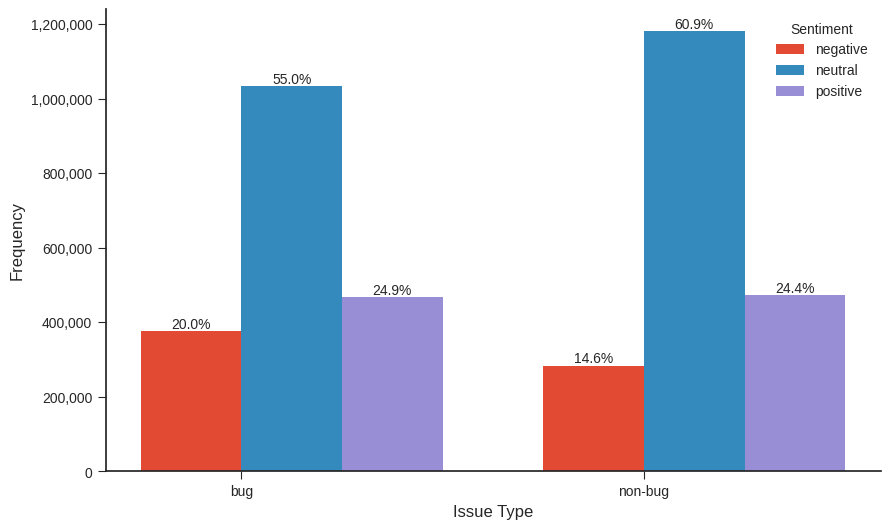

In [87]:
grouped = rq34.groupby(['issuetype', 'text_sentiment']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))  

sentiments = grouped.columns
issue_types = grouped.index

bar_width = 0.25
bar_positions = list(range(len(issue_types)))

for i, sentiment in enumerate(sentiments):
    offset = i * bar_width - bar_width / 2

    bars = plt.bar([pos + offset for pos in bar_positions], grouped[sentiment], width=bar_width, label=sentiment)
    
    for bar, pct in zip(bars, grouped_percent[sentiment]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)


# Customize plot
plt.xlabel('Issue Type')
plt.ylabel('Frequency')
# plt.title('Sentiment Frequencies by Issue Type')
plt.xticks(bar_positions, issue_types)
plt.legend(title='Sentiment', loc='upper right')
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)  
plt.gca().get_xaxis().tick_bottom() 
plt.gca().get_yaxis().tick_left()  
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(False)
plt.show()

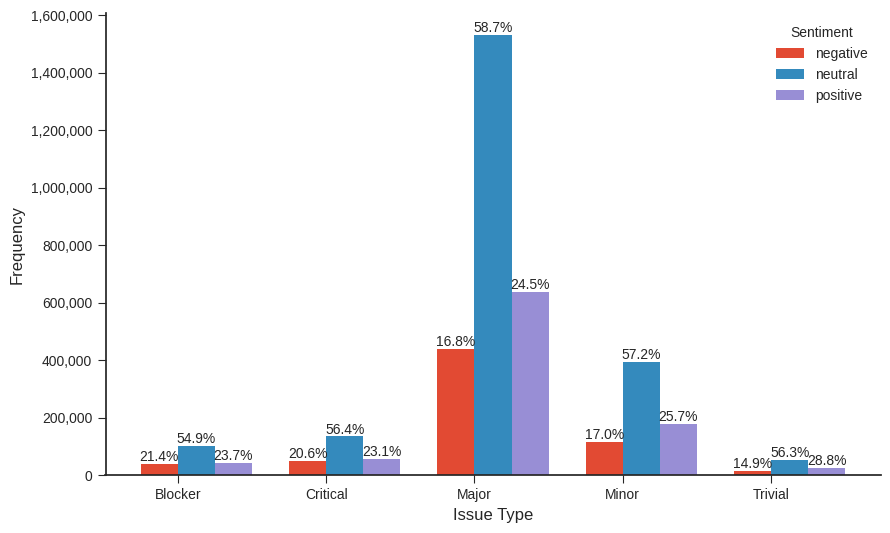

In [88]:
grouped = rq34.groupby(['priority', 'text_sentiment']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))  

priorities = grouped.columns
issue_types = grouped.index

bar_width = 0.25
bar_positions = list(range(len(issue_types)))

for i, priority in enumerate(priorities):
    offset = i * bar_width - bar_width / 2

    bars = plt.bar([pos + offset for pos in bar_positions], grouped[priority], width=bar_width, label=priority)
    
    for bar, pct in zip(bars, grouped_percent[priority]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

# Customize plot
plt.xlabel('Issue Type')
plt.ylabel('Frequency')
# plt.title('Sentiment Frequencies by Issue Priority')
plt.xticks(bar_positions, issue_types)
plt.legend(title='Sentiment', loc='upper right')
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)  
plt.gca().get_xaxis().tick_bottom() 
plt.gca().get_yaxis().tick_left()  
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(False)
plt.show()

In [89]:
mean_cumulative_scores = rq34.groupby('priority')['sentiment_score_cumulative'].mean().reset_index()
mean_positive_scores = rq34.groupby('priority')['sentiment_score_positive'].mean().reset_index()
mean_negative_scores = rq34.groupby('priority')['sentiment_score_negative'].mean().reset_index()

mean_scores = mean_cumulative_scores.merge(mean_positive_scores, on='priority')
mean_scores = mean_scores.merge(mean_negative_scores, on='priority')
mean_scores

,priority,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
0,Blocker,0.248564,5.131044,4.882480
1,Critical,0.550576,5.048442,4.497865
2,Major,1.257710,4.421778,3.164068
3,Minor,1.055568,3.632485,2.576917
4,Trivial,1.082518,2.599562,1.517045


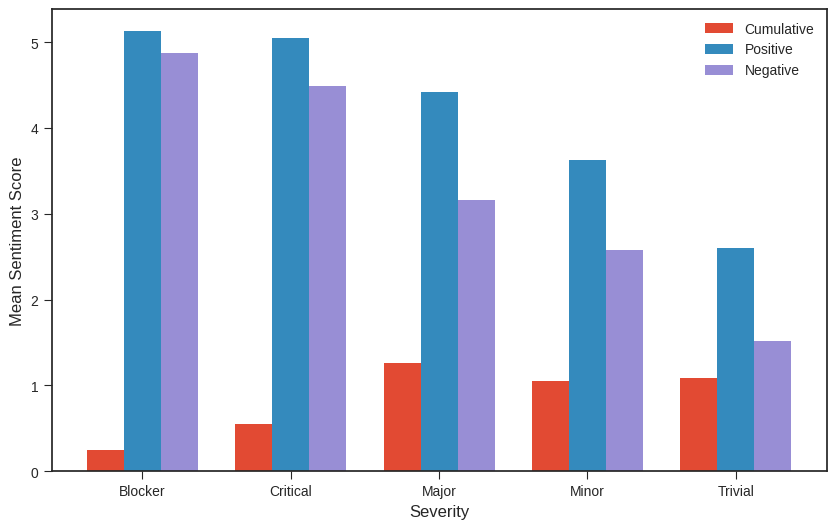

In [91]:
plt.figure(figsize=(10, 6))

bar_width = 0.25
bar_positions = list(range(len(mean_scores)))

plt.bar([pos - bar_width for pos in bar_positions], mean_scores['sentiment_score_cumulative'], width=bar_width, label='Cumulative')
plt.bar(bar_positions, mean_scores['sentiment_score_positive'], width=bar_width, label='Positive')
plt.bar([pos + bar_width for pos in bar_positions], mean_scores['sentiment_score_negative'], width=bar_width, label='Negative')

plt.xlabel('Severity')
plt.ylabel('Mean Sentiment Score')
# plt.title('Mean Sentiment Scores by Priority')
plt.xticks(bar_positions, mean_scores['priority'])
plt.legend()
plt.show()